# Trafic sign classification for Self-Driving Car



### Importing libraries

In [2]:
import pickle
import sklearn
import os
import zipfile
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D


---
## Step 0: Load The Data

In [35]:
# Load pickled data

# Mount Google drive
drive.mount('/content/drive')

# Extract the Dataset
# Path to the zip file in Drive
zip_path = '/content/drive/My Drive/German-Traffic-Sign.zip'

# Extraction directory
extract_path = '/content/dataset'

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


# Paths to extracted files
training_file = '/content/dataset/train.p'
validation_file = '/content/dataset/valid.p'
testing_file = '/content/dataset/test.p'
signnames_file = '/content/dataset/signname.csv'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Explore the data
print("Train Keys:", train.keys())
print("Number of training examples:", len(train['features']))
print("Feature shape:", train['features'].shape)
print("Labels shape:", train['labels'].shape)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to: /content/dataset
Train Keys: dict_keys(['coords', 'labels', 'features', 'sizes'])
Number of training examples: 34799
Feature shape: (34799, 32, 32, 3)
Labels shape: (34799,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


### Basic Summary of the Dataset

In [13]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(ar=y_train).shape[0]

image_depth_dimension = X_train.shape[3]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43




#### So, what do the images in the dataset look like?

The images are 32x32x3, meaning they are very low resolution color images.
Below, I am showing how the images look like, chosen at random.

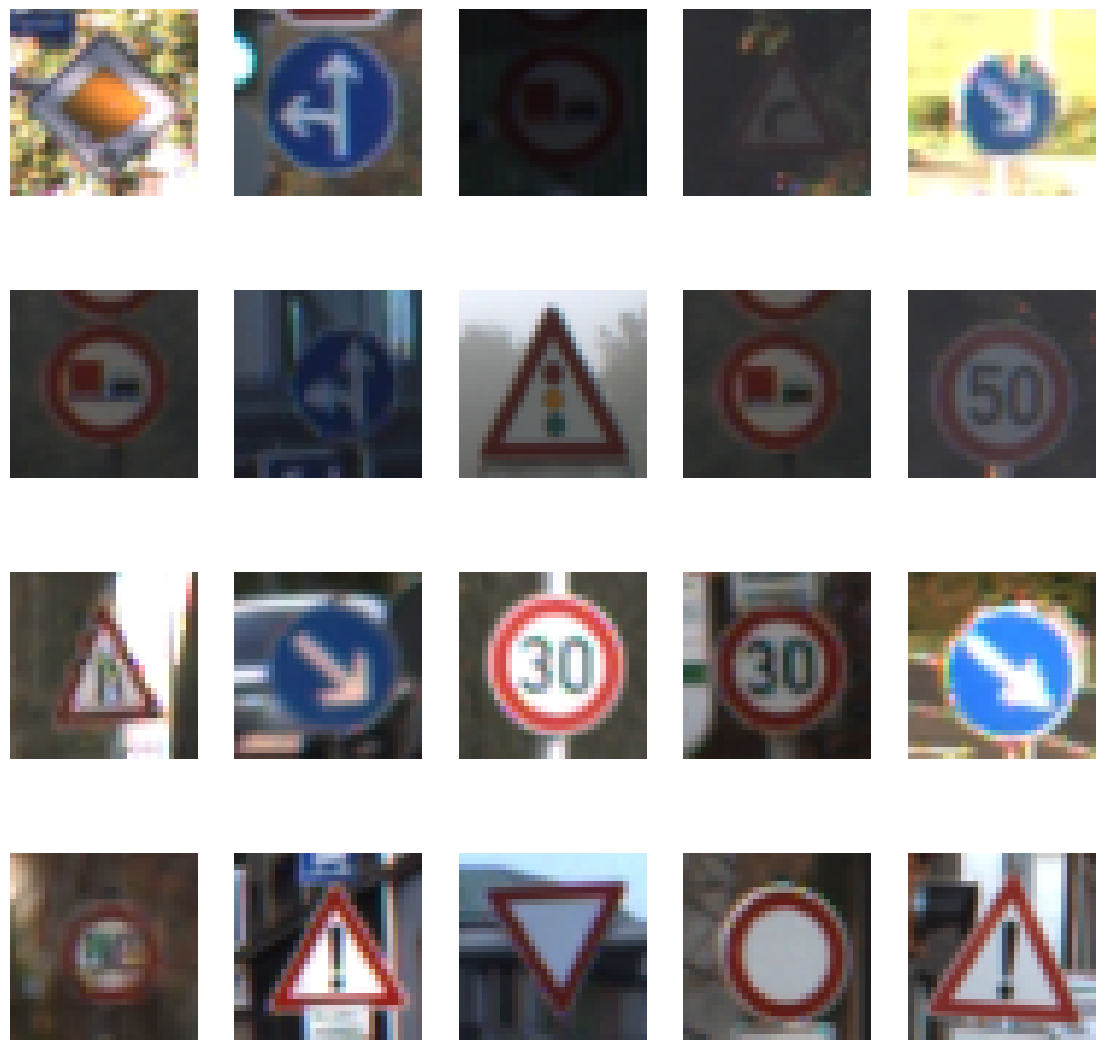

In [ ]:
# Visualizations will be shown in the notebook.
%matplotlib inline
fig=plt.figure(figsize=(14, 14))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    # show random images from the dataset
    img = X_train[randint(0, n_train-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()


## Class Distribution

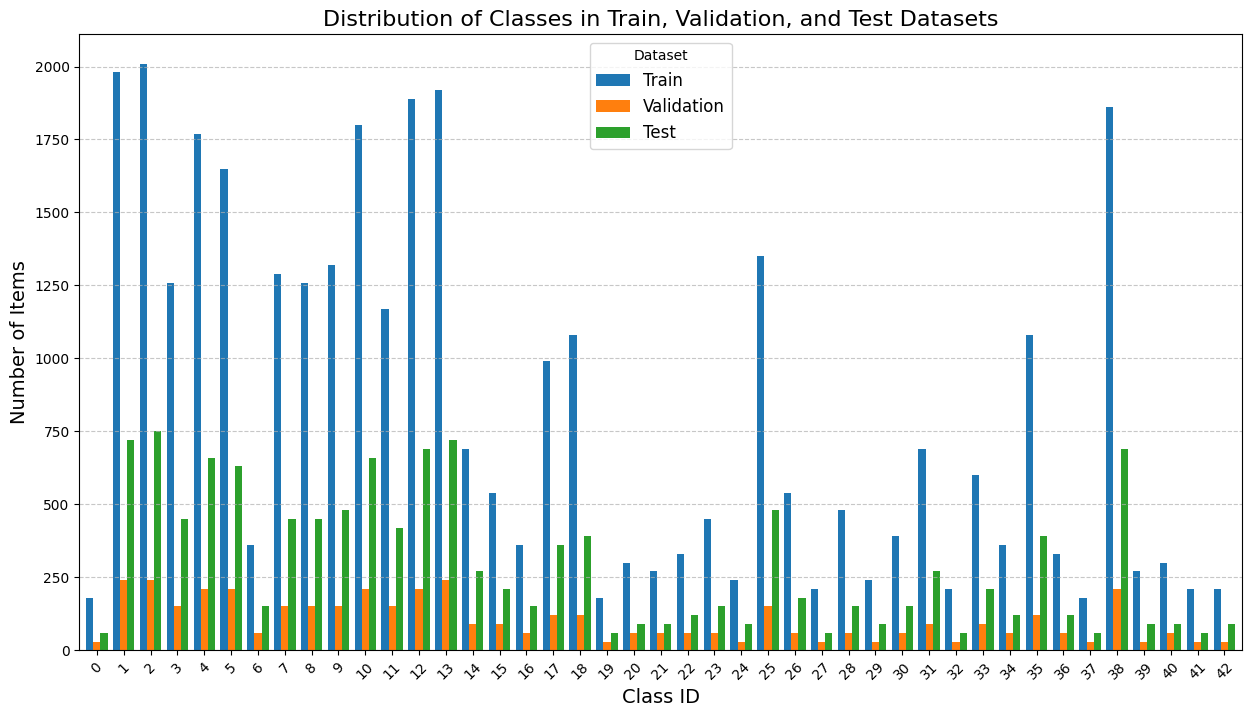

In [ ]:
# Extract the labels from each dataset
train_labels = train['labels']
valid_labels = valid['labels']
test_labels = test['labels']

# Count the occurrences of each class
train_counts = np.bincount(train_labels)
valid_counts = np.bincount(valid_labels)
test_counts = np.bincount(test_labels)

# Create a DataFrame for better visualization
class_distribution = pd.DataFrame({
    'Class': range(len(train_counts)),
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})

# Plot the data
class_distribution.set_index('Class').plot(kind='bar', figsize=(15, 8), width=0.8)
plt.title('Distribution of Classes in Train, Validation, and Test Datasets', fontsize=16)
plt.xlabel('Class ID', fontsize=14)
plt.ylabel('Number of Items', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Dataset', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

----

## Step 2 : The LeNet5 Model without Dropout

In [ ]:
model1 = Sequential([
    # C1: Convolutional layer with 6 filters 5x5, ReLU activation, input 32x32x3
    Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),

    # S2: SubSampling (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # C3: Second convolutional layer with 16 filters 5x5, ReLU activation
    Conv2D(16, (5, 5), activation='relu'),

    # S4: SubSampling (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # Flatten to transition to dense layers
    Flatten(),

    # C5: Fully connected layer with 120 neurons
    Dense(120, activation='relu'),

    # F6: Fully connected layer with 84 neurons
    Dense(84, activation='relu'),

    # Output layer with 43 neurons (for 43 classification classes)
    Dense(43, activation='softmax')
])

# Display the model summary
model1.summary()

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 14, 14, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │           3,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,811 (253.17 KB)

 Trainable params: 64,811 (253.17 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
training1 = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5742 - loss: 1.9987 - val_accuracy: 0.8311 - val_loss: 0.7008
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9342 - loss: 0.2525 - val_accuracy: 0.8830 - val_loss: 0.5419
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9611 - loss: 0.1481 - val_accuracy: 0.8925 - val_loss: 0.5678
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9724 - loss: 0.1052 - val_accuracy: 0.9077 - val_loss: 0.3882
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9748 - loss: 0.0904 - val_accuracy: 0.9005 - val_loss: 0.5668
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9823 - loss: 0.0689 - val_accuracy: 0.9045 - val_loss: 0.8695
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9815 - loss: 0.0701 - val_accuracy: 0.9050 - val_loss: 0.6317
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9838 - loss: 0.0628

### Evaluate on test and validation data

In [ ]:
test_loss_model1, test_accuracy_model1 = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_model1 * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9162 - loss: 0.7239
Test Accuracy: 91.55%


In [ ]:
val_loss_model1, val_accuracy_model1 = model1.evaluate(X_valid, y_valid)

print(f"Validation Loss: {val_loss_model1 * 100:.2f}%")
print(f"Validation Accuracy:{ val_accuracy_model1 * 100:.2f}%")

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9074 - loss: 0.7842
Validation Loss: 72.17%
Validation Accuracy:92.34%


## Observations

### Initial Performance (Epoch 1):

- **Training Accuracy**: 0.5742 (57.42%)
- **Training Loss**: 1.9987
  - The model starts with relatively low accuracy, indicating it is still learning basic features.
- **Validation Accuracy**: 0.8311 (83.11%)
- **Validation Loss**: 0.7008
  - Validation accuracy is higher than training accuracy, which might suggest the model initially generalizes well.

### Improvement Over Epochs:

- Training accuracy increases significantly, reaching 98.42% by epoch 10.
- Training loss decreases consistently, from 1.9987 in epoch 1 to 0.0653 in epoch 10.
- Validation accuracy fluctuates slightly but remains high, reaching 92.34% by epoch 10.

### Validation Loss Behavior:

- Validation loss decreases initially, indicating improved generalization.
- However, it starts fluctuating and increases in later epochs (e.g., 0.8695 in epoch 6, 0.7217 in epoch 10), suggesting overfitting.
  - Overfitting occurs when the model performs very well on the training data but struggles to generalize to unseen validation data.

### Final Performance:

- **Training Accuracy**: 98.42%
- **Validation Accuracy**: 92.34%
  - A good gap (~6%) between training and validation accuracy suggests the model is performing well but might be slightly **overfitting**.


----
## Step 3 : The LeNet5 model with dropout

In [5]:
# Define the model
model2 = Sequential([
    # C1: Convolutional layer with 6 filters 5x5, ReLU activation, input 32x32x3
    Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    # Dropout after the first convolutional layer
    Dropout(0.2),  # Drop 20% of neurons randomly
    # Explanation: Helps prevent reliance on specific features in the initial convolution.

    # S2: SubSampling (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # C3: Second convolutional layer with 16 filters 5x5, ReLU activation
    Conv2D(16, (5, 5), activation='relu'),
    # Dropout after the second convolutional layer
    Dropout(0.3),  # Drop 30% of neurons randomly
    # Explanation: Further reduces reliance on specific filters and promotes generalization.

    # S4: SubSampling (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # Flatten to transition to dense layers
    Flatten(),

    # C5: Fully connected layer with 120 neurons
    Dense(120, activation='relu'),
    # Dropout after the first dense layer
    Dropout(0.5),  # Drop 50% of neurons randomly
    # Explanation: Dense layers have a high number of parameters, making them prone to overfitting. A higher dropout rate is suitable here.

    # F6: Fully connected layer with 84 neurons
    Dense(84, activation='relu'),
    # Dropout after the second dense layer
    Dropout(0.5),  # Drop 50% of neurons randomly
    # Explanation: Helps further reduce overfitting in fully connected layers.

    # Output layer with 43 neurons (for 43 classification classes)
    Dense(43, activation='softmax')
])

# Display the model summary
model2.summary()

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │           3,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,811 (253.17 KB)

 Trainable params: 64,811 (253.17 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
training2 = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.1204 - loss: 5.8561 - val_accuracy: 0.4712 - val_loss: 1.7793
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.4481 - loss: 1.8764 - val_accuracy: 0.6918 - val_loss: 1.0218
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - accuracy: 0.5962 - loss: 1.3002 - val_accuracy: 0.7730 - val_loss: 0.7915
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - accuracy: 0.6680 - loss: 1.0674 - val_accuracy: 0.7900 - val_loss: 0.5923
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7282 - loss: 0.8893 - val_accuracy: 0.8109 - val_loss: 0.5652
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.7497 - loss: 0.7941 - val_accuracy: 0.8728 - val_loss: 0.4540
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.7699 - loss: 0.7464 - val_accuracy: 0.8844 - val_loss: 0.4079
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.7937 -

### Augment the epochs size to 25

In [7]:
training2 = model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=32)

Epoch 1/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.3361 - loss: 2.3782 - val_accuracy: 0.4850 - val_loss: 1.5864
Epoch 2/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.4760 - loss: 1.7154 - val_accuracy: 0.6528 - val_loss: 1.1612
Epoch 3/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.5794 - loss: 1.3443 - val_accuracy: 0.7379 - val_loss: 0.8916
Epoch 4/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.6473 - loss: 1.1113 - val_accuracy: 0.7703 - val_loss: 0.7190
Epoch 5/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/step - accuracy: 0.6982 - loss: 0.9616 - val_accuracy: 0.8036 - val_loss: 0.5860
Epoch 6/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7282 - loss: 0.8648 - val_accuracy: 0.8533 - val_loss: 0.5005
Epoch 7/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.7489 - loss: 0.8071 - val_accuracy: 0.8415 - val_loss: 0.5060
Epoch 8/25
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.7765 -

### Evaluate on test and validation data

In [8]:
test_loss_model2, test_accuracy_model2 = model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_model2 * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9125 - loss: 0.3257
Test Accuracy: 91.60%


In [9]:
val_loss_model2, val_accuracy_model2 = model2.evaluate(X_valid, y_valid)

print(f"Validation Loss: {val_loss_model2 * 100:.2f}%")
print(f"Validation Accuracy:{ val_accuracy_model2 * 100:.2f}%")

138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9336 - loss: 0.2654
Validation Loss: 24.17%
Validation Accuracy:93.83%


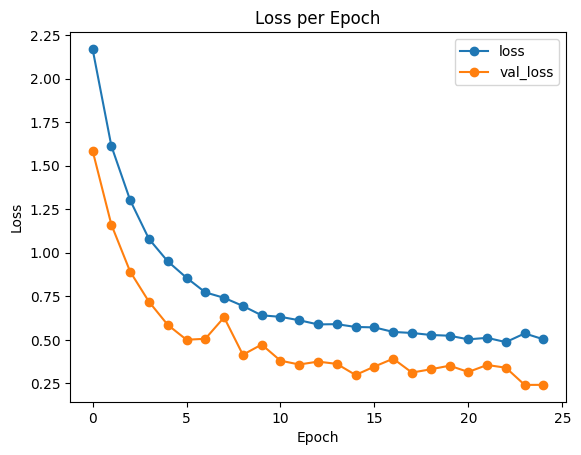

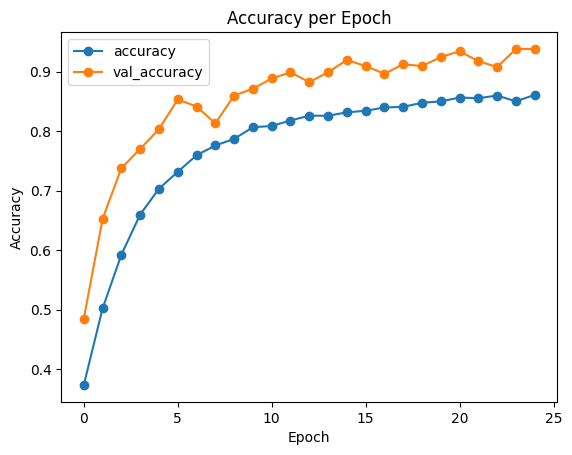

In [10]:
# Convertir l'historique en DataFrame
training2_history= pd.DataFrame(training2.history)

# Tracer les courbes d'entraînement et de validation
training2_history[['loss', 'val_loss']].plot(title='Loss per Epoch', xlabel='Epoch', ylabel='Loss', marker='o')
training2_history[['accuracy', 'val_accuracy']].plot(title='Accuracy per Epoch', xlabel='Epoch', ylabel='Accuracy', marker='o')

plt.show()

----

## Step 4 : Design and Test another Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project.

Here, I am using a simple normalization technique - (x-min)/(max-min) for all the pixels in the image.

What this does is essentially normalizes the pixel values to between 0 and 1, thereby chaning contrast. Images before and after normalization are shown below.

In [11]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [length, width, color_depth]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [14]:
normalized_train = np.zeros([n_train,32,32,3])
normalized_validation = np.zeros([n_validation,32,32,3])
normalized_test = np.zeros([n_test,32,32,3])
for i in range(0,n_train):
    normalized_train[i] = normalize(X_train[i])
for i in range(0,n_validation):
    normalized_validation[i] = normalize(X_valid[i])
for i in range(0,n_test):
    normalized_test[i] = normalize(X_test[i])

assert(X_train.shape==normalized_train.shape)

### Show the difference normalization makes

Text(0.5, 1.0, 'Normalized Image')

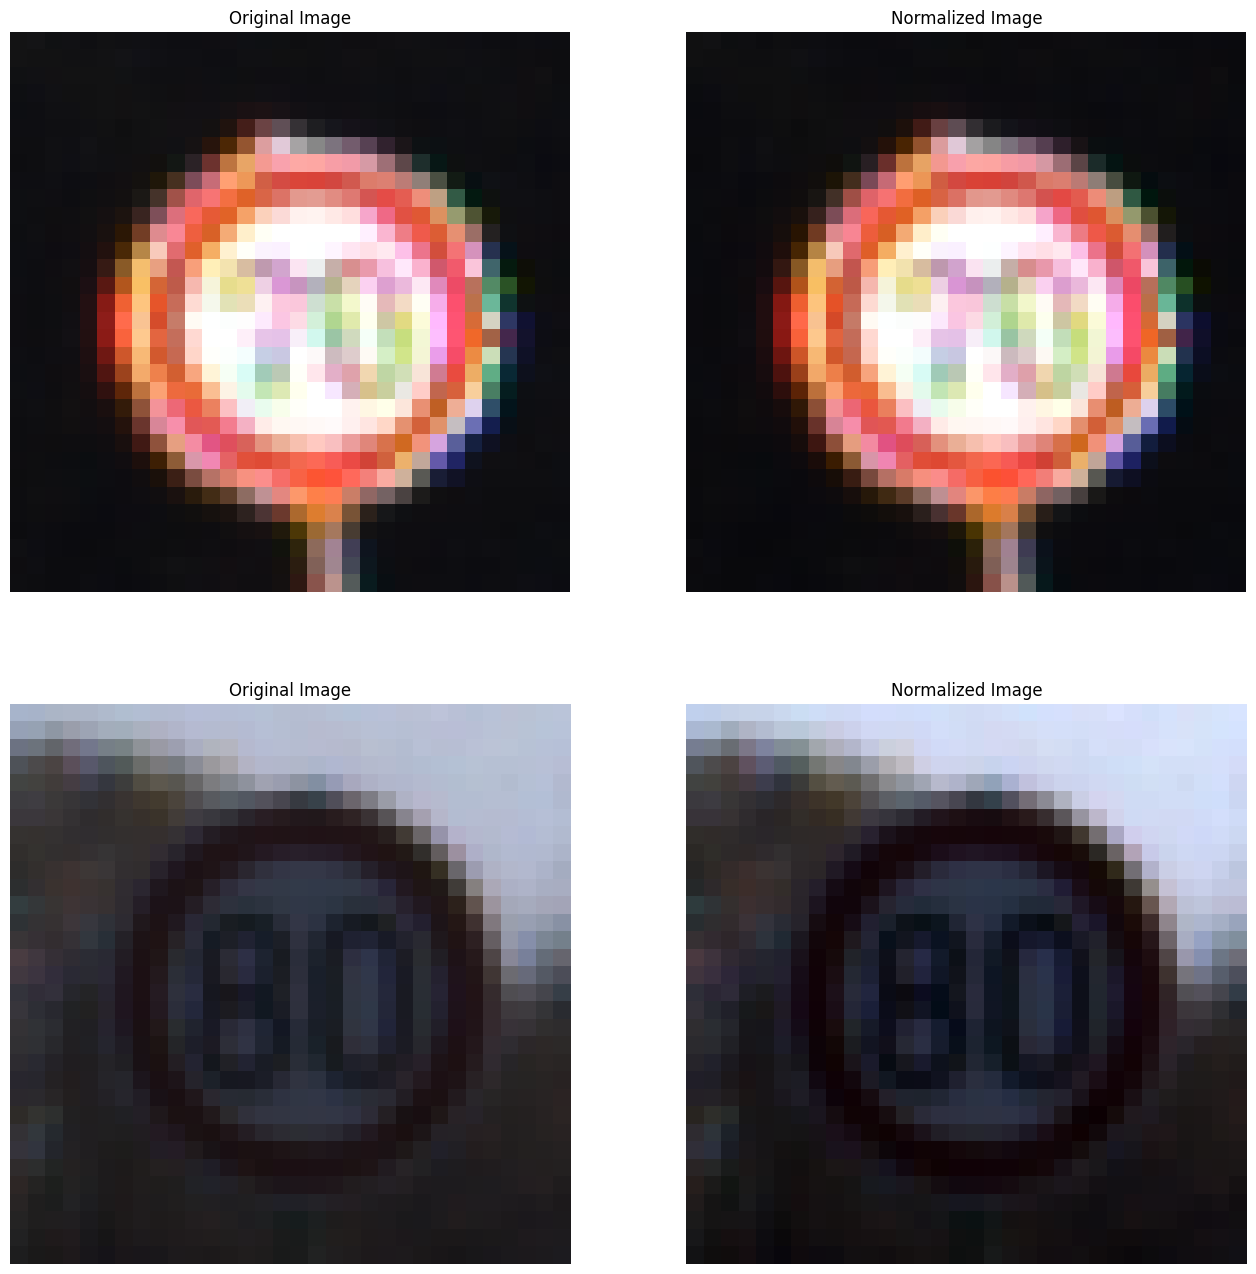

In [15]:
f, axarr = plt.subplots(nrows=2,ncols=2,figsize = (16,16))
randomindex = randint(0,n_train-1)
axarr[0,0].imshow(X_train[randomindex])
axarr[0,0].axis('off')
axarr[0,0].set_title('Original Image')
axarr[0,1].imshow(normalized_train[randomindex])
axarr[0,1].axis('off')
axarr[0,1].set_title('Normalized Image')
randomindex = randint(0,n_train-1)
axarr[1,0].imshow(X_train[randomindex])
axarr[1,0].axis('off')
axarr[1,0].set_title('Original Image')
axarr[1,1].imshow(normalized_train[randomindex])
axarr[1,1].axis('off')
axarr[1,1].set_title('Normalized Image')

### Make the normalized dataset the set to be used in the model

In [16]:
X_train = normalized_train

X_valid = normalized_validation

X_test = normalized_test

### Model Architecture

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model3 = Sequential([
    # C1: Convolutional layer with 6 filters 5x5, ReLU activation, input 32x32x3
    Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='valid'),
    MaxPooling2D(pool_size=(2, 2)),

    # C3: Second convolutional layer with 16 filters 5x5, ReLU activation
    Conv2D(16, (5, 5), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2)),

    # Extra convolutional layer (Added Improvement)
    Conv2D(412, (5, 5), activation='relu', padding='valid'),

    # Flatten for fully connected layers
    Flatten(),

    # Fully connected layers with dropout (Added Improvement)
    Dense(122, activation='relu'),
    Dropout(0.5),  # Dropout with 50% rate
    Dense(84, activation='relu'),
    Dropout(0.5),  # Dropout with 50% rate

    # Output layer for 43 classes
    Dense(43, activation='softmax')
])

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 1, 1, 412)           │         165,212 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 412)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 122)                 │          50,386 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 122)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 84)                  │          10,332 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 43)                  │           3,655 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,457 (908.04 KB)

 Trainable params: 232,457 (908.04 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [29]:

from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint to save the best model
checkpoint = ModelCheckpoint('lenet_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Add print statements to check shapes of input data
print("X_train shape:", X_train.shape)  # Verify X_train is not empty
print("y_train shape:", y_train.shape)  # Verify y_train is not empty

# Train the model with Keras
training3 = model3.fit(
    X_train, y_train,
    epochs=25,
    batch_size=156,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint],
    verbose=1
)

# Add a check if training3 is None, if so print an error message, else proceed
if training3 is None:
    print("Error: model3.fit() returned None. Check for potential issues in your model or data.")
else:
    # Evaluate the model on the validation dataset
    final_accuracy = model3.evaluate(X_valid, y_valid, verbose=0)
    print(f"Validation Accuracy: {final_accuracy[1]}")


X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
Epoch 1/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.1440 - loss: 3.2227 - val_accuracy: 0.5800 - val_loss: 1.3941
Epoch 2/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.5750 - loss: 1.3471 - val_accuracy: 0.8184 - val_loss: 0.6350
Epoch 3/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.7462 - loss: 0.7770 - val_accuracy: 0.8499 - val_loss: 0.4584
Epoch 4/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.8239 - loss: 0.5419 - val_accuracy: 0.8893 - val_loss: 0.3795
Epoch 5/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.8719 - loss: 0.4080 - val_accuracy: 0.9179 - val_loss: 0.2942
Epoch 6/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9025 - loss: 0.3037 - val_accuracy: 0.9240 - val_loss: 0.2755
Epoch 7/25
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.9231 - loss: 0.2501 - val_accuracy: 0.9293 - val_loss: 0.2631
Epoch 8/25
224/224 ━━━━━━

### Plot the accuracies, make sense of them

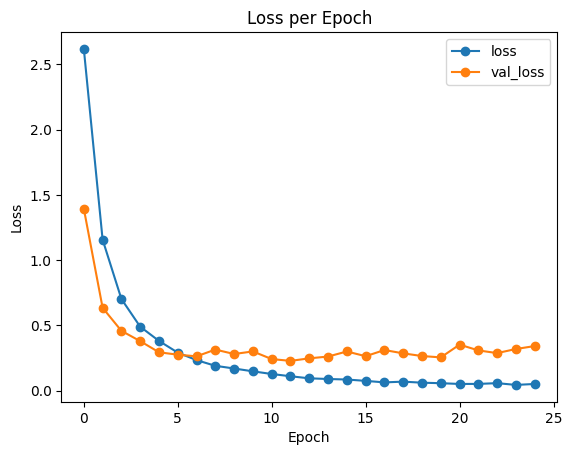

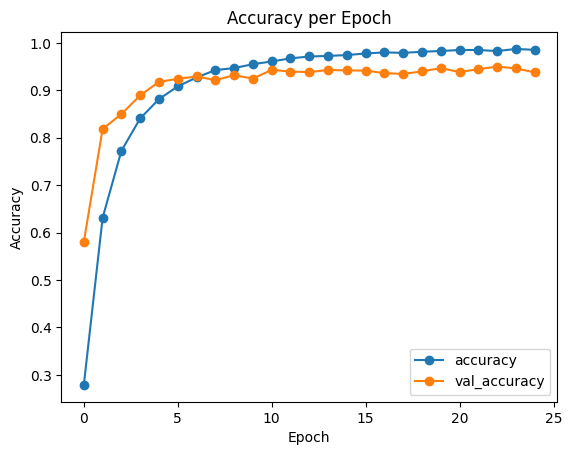

In [30]:
# Convertir l'historique en DataFrame
training3_history= pd.DataFrame(training3.history)

# Tracer les courbes d'entraînement et de validation
training3_history[['loss', 'val_loss']].plot(title='Loss per Epoch', xlabel='Epoch', ylabel='Loss', marker='o')
training3_history[['accuracy', 'val_accuracy']].plot(title='Accuracy per Epoch', xlabel='Epoch', ylabel='Accuracy', marker='o')

plt.show()

---

## Step 5: Test the Model on New Images

To provide more insight into how the model is working, I downloaded 6 pictures of German traffic signs from the web and used the model to predict the traffic sign type.

The `signnames.csv` is useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

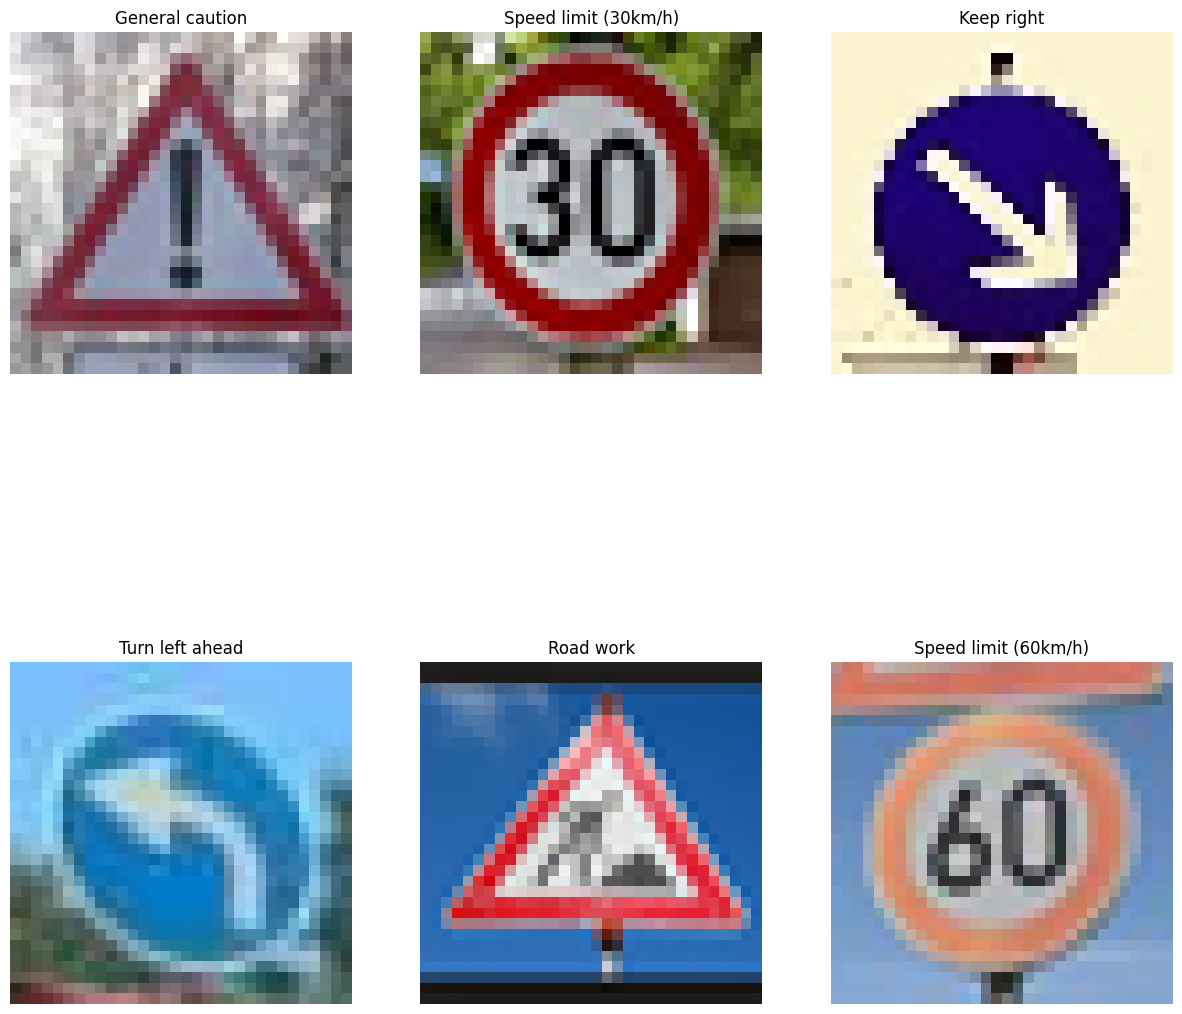

In [36]:
# Load and plot images
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_folder_path = '/content/drive/My Drive/new_signs/*.png'

# Load images and their labels
my_images = sorted(glob.glob(image_folder_path))
my_labels = np.array([18, 1, 38, 34, 25, 3])  # Example labels (modify according to your case)

# Load the sign names from 'signnames.csv' (ensure the path is correct)
name_values = np.genfromtxt(signnames_file,
                            skip_header=1,
                            dtype=[('myint', 'i8'), ('mystring', 'S55')],
                            delimiter=',')

# Initialize storage for figures and labels
figures = {}
labels = {}
my_signs = []

# Process images and associate labels
index = 0
for my_image in my_images:
    # Read and convert the image
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')  # Decoding to string
    index += 1

# Plot images with labels
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
i, j = 0, 0
for idx in range(len(figures)):
    ax[i, j].imshow(figures[idx])
    ax[i, j].axis('off')
    ax[i, j].set_title(labels[idx])
    j += 1
    if j == 3:
        j = 0
        i = 1

plt.show()


### Normalize the images from the web

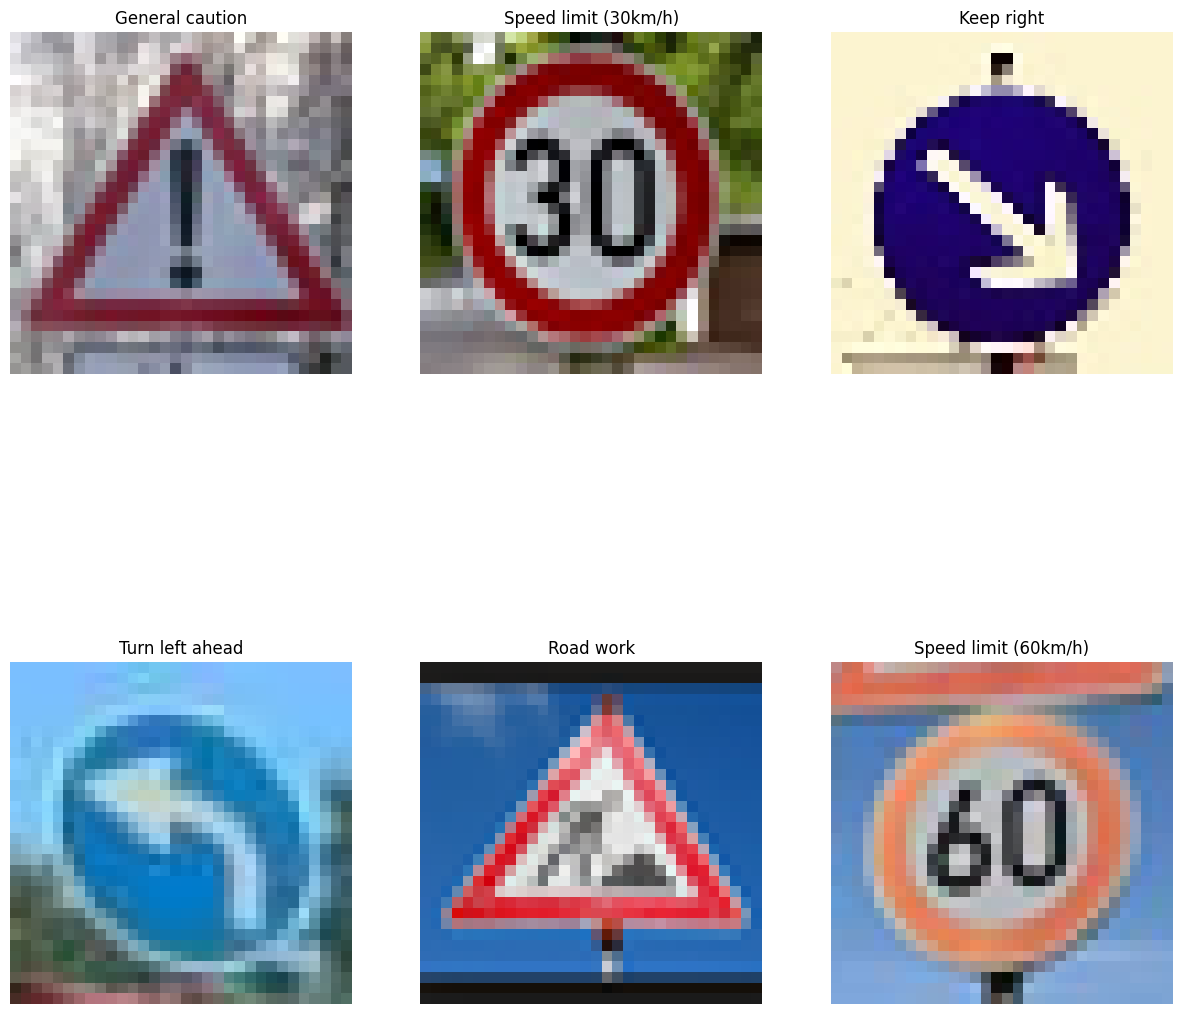

In [37]:
my_signs = np.array(my_signs)
my_signs_norm=[]
for i in range(len(my_signs)):
    my_signs_norm.append(normalize(my_signs[i]))

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))
i=0
j=0
for idx in range(len(my_signs_norm)):

    ax[i,j].imshow(my_signs_norm[idx])
    ax[i,j].axis('off')
    ax[i,j].set_title(labels[idx])
    j+=1
    if j==3:
        j=0
        i=1

#### Convert to array

In [38]:
my_signs_normalized = np.asarray(my_signs_norm)
print(my_signs_normalized)

[[[[0.88       0.876      0.896     ]
   [0.82       0.816      0.844     ]
   [0.74       0.736      0.76      ]
   ...
   [0.552      0.516      0.508     ]
   [0.796      0.764      0.752     ]
   [0.528      0.496      0.484     ]]

  [[0.924      0.92       0.944     ]
   [0.76       0.756      0.78      ]
   [0.708      0.704      0.728     ]
   ...
   [0.488      0.448      0.448     ]
   [0.58       0.548      0.548     ]
   [0.412      0.376      0.376     ]]

  [[0.864      0.86       0.876     ]
   [0.76       0.756      0.776     ]
   [0.78       0.776      0.792     ]
   ...
   [0.396      0.356      0.364     ]
   [0.52       0.484      0.496     ]
   [0.392      0.356      0.368     ]]

  ...

  [[0.564      0.56       0.548     ]
   [0.56       0.56       0.552     ]
   [0.452      0.448      0.452     ]
   ...
   [0.312      0.32       0.332     ]
   [0.424      0.448      0.476     ]
   [0.384      0.4        0.44      ]]

  [[0.656      0.656      0.644     ]
   [0.5

### Predict the Sign Type for Each Image

In [39]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained Keras model
model = load_model('/content/lenet_best_model.keras')

# Ensure images are in the correct shape and normalized
# Assume `my_signs_normalized` is already normalized and in (6, 32, 32, 3) shape
print("Shape of my_signs_normalized:", my_signs_normalized.shape)

# Predict the sign types
predictions = model.predict(my_signs_normalized)

# Decode predictions
predicted_classes = np.argmax(predictions, axis=1)
print("Predicted classes:", predicted_classes)

# Map predicted classes to labels
for idx, pred_class in enumerate(predicted_classes):
    print(f"Image {idx + 1}: Predicted Class = {pred_class}, True Label = {my_labels[idx]}")


Shape of my_signs_normalized: (6, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Predicted classes: [18  1 38 34 25  3]
Image 1: Predicted Class = 18, True Label = 18
Image 2: Predicted Class = 1, True Label = 1
Image 3: Predicted Class = 38, True Label = 38
Image 4: Predicted Class = 34, True Label = 34
Image 5: Predicted Class = 25, True Label = 25
Image 6: Predicted Class = 3, True Label = 3


### Analyze Performance

In [40]:
# Evaluate the accuracy of the model on the new dataset
accuracy = model.evaluate(my_signs_normalized, my_labels, verbose=0)
print("My Data Set Accuracy = {:.2f}%".format(accuracy[1] * 100))

# Analyzing performance image-by-image
test_signs_label = my_labels

for i in range(len(my_signs_normalized)):
    # Select a single image and its label
    test_image = my_signs_normalized[i].reshape(1, 32, 32, 3)  # Reshape to match input dimensions
    test_label = test_signs_label[i]

    # Predict the sign type
    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the result
    print(f"Image {i + 1}: Predicted Class = {predicted_class}, True Label = {test_label}")
    if predicted_class == test_label:
        print("Correct Prediction!")
    else:
        print("Incorrect Prediction!")


My Data Set Accuracy = 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Image 1: Predicted Class = 18, True Label = 18
Correct Prediction!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 2: Predicted Class = 1, True Label = 1
Correct Prediction!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image 3: Predicted Class = 38, True Label = 38
Correct Prediction!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 4: Predicted Class = 34, True Label = 34
Correct Prediction!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 5: Predicted Class = 25, True Label = 25
Correct Prediction!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 6: Predicted Class = 3, True Label = 3
Correct Prediction!


----
# Models Recap


In [2]:
import pandas as pd
from tabulate import tabulate

# Extract values from training history
# Example: Replace `training1` with the actual history objects from your training
train_accuracy_model1 = training1.history['accuracy'][-1]
train_loss_model1 = training1.history['loss'][-1]
val_accuracy_model1 = training1.history['val_accuracy'][-1]
val_loss_model1 = training1.history['val_loss'][-1]

train_accuracy_model2 = training2.history['accuracy'][-1]
train_loss_model2 = training2.history['loss'][-1]
val_accuracy_model2 = training2.history['val_accuracy'][-1]
val_loss_model2 = training2.history['val_loss'][-1]

train_accuracy_model3 = training3.history['accuracy'][-1]
train_loss_model3 = training3.history['loss'][-1]
val_accuracy_model3 = training3.history['val_accuracy'][-1]
val_loss_model3 = training3.history['val_loss'][-1]

# Example test metrics: Replace these with the actual test evaluations
test_loss_model1, test_accuracy_model1 = model1.evaluate(X_test, y_test, verbose=0)
test_loss_model2, test_accuracy_model2 = model2.evaluate(X_test, y_test, verbose=0)
test_loss_model3, test_accuracy_model3 = model3.evaluate(X_test, y_test, verbose=0)

# Organize results in a dictionary
results = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Train Accuracy': [train_accuracy_model1, train_accuracy_model2, train_accuracy_model3],
    'Train Loss': [train_loss_model1, train_loss_model2, train_loss_model3],
    'Validation Accuracy': [val_accuracy_model1, val_accuracy_model2, val_accuracy_model3],
    'Validation Loss': [val_loss_model1, val_loss_model2, val_loss_model3],
    'Test Accuracy': [test_accuracy_model1, test_accuracy_model2, test_accuracy_model3],
    'Test Loss': [test_loss_model1, test_loss_model2, test_loss_model3],
}

# Convert accuracies to percentages for better readability
results['Train Accuracy'] = [acc * 100 for acc in results['Train Accuracy']]
results['Validation Accuracy'] = [acc * 100 for acc in results['Validation Accuracy']]
results['Test Accuracy'] = [acc * 100 for acc in results['Test Accuracy']]

# Create a DataFrame
results_df = pd.DataFrame(results)

# Format the display for percentages
pd.options.display.float_format = '{:,.2f}%'.format

# Print the DataFrame
print(results_df)

# Optional: Display as a formatted table
print("\nFormatted Summary Table:\n")
print(tabulate(results_df, headers='keys', tablefmt='pretty'))


     Model  Train Accuracy  Train Loss  Validation Accuracy  Validation Loss  \
0  Model 1          98.42%       6.53%               90.74%           78.42%   
1  Model 2          86.02%      50.08%               93.83%           24.17%   
2  Model 3          98.52%       5.39%               93.79%           34.19%   

   Test Accuracy  Test Loss  
0         91.62%     72.39%  
1         91.60%     32.57%  
2         94.76%     20.14%  

Formatted Summary Table:

+---+---------+----------------+--------------------+---------------------+--------------------+-------------------+-----------+
|   |  Model  | Train Accuracy |     Train Loss     | Validation Accuracy |  Validation Loss   |   Test Accuracy   | Test Loss |
+---+---------+----------------+--------------------+---------------------+--------------------+-------------------+-----------+
| 0 | Model 1 |     98.42      | 6.529999999999999  |        90.74        |       78.42        |       91.62       |   72.39   |
| 1 | Model 2 | 